<a href="https://colab.research.google.com/github/PimpatcharaCh/229352-StatisticalLearning2/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

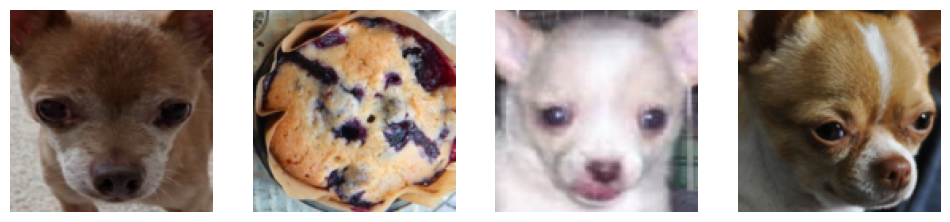

tensor([0, 1, 0, 0])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [29]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super(SimpleLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3*128*128, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [31]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [32]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [33]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [34]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [36]:
for X_batch, y_batch in train_loader:

    y_batch = y_batch.long()

    y_hat = model(X_batch)

    loss = criterion(y_hat, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


#### Make a prediction on the minibatch (Forward pass)

In [37]:
y_hat = y_hat[:, 0]
y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [38]:
# Compute the loss
y_hat = torch.sigmoid(y_hat)
y_batch = y_batch.long()

#### Calculate the gradient (Backward pass)

In [41]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
for X_batch, y_batch in train_loader:

    optimizer.zero_grad()

    y_hat = model(X_batch)
    loss = criterion(y_hat, y_batch)

    loss.backward()
    optimizer.step()

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [42]:
# Update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [43]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([ -8.3146,  -9.8420,  -4.0712,   3.4916,  -0.8300,  -7.0672,   1.8268,
         -5.8505,  -1.5475,   0.7923,   0.6365, -13.3439,  -7.2215,  -5.5311,
          2.7608, -12.7045,   2.1377,  -5.5659,  -4.0870,  -6.9112,  -4.4208,
         -1.5451,  -8.7771,  -8.3616]) tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 1.])


In [44]:
print(train_losses)
print(val_losses)

[]
[138.93910217285156]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

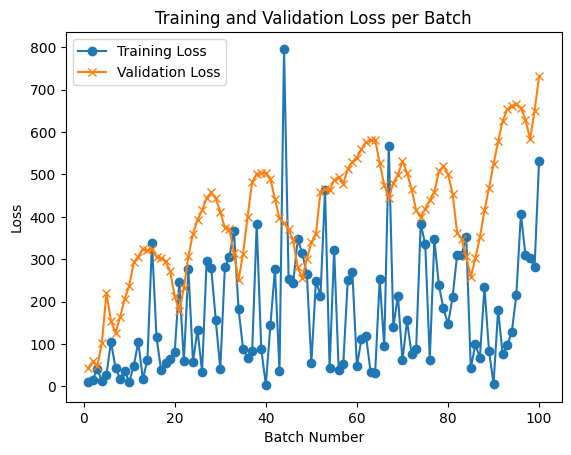

In [45]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [46]:
# 1

class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()

        self.flatten = nn.Flatten()

        self.net = nn.Sequential(
            nn.Linear(3*128*128, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 2)   # 2 classes
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

In [47]:
# 2
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

for lr in learning_rates:

    model = DeepNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(f"\nTraining with lr = {lr}")

    for epoch in range(5):
        model.train()
        running_loss = 0

        for X_batch, y_batch in train_loader:
            y_batch = y_batch.long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")



Training with lr = 0.01
Epoch 1, Loss: 13.4187
Epoch 2, Loss: 1.1099
Epoch 3, Loss: 1.1867
Epoch 4, Loss: 1.0357
Epoch 5, Loss: 0.6508

Training with lr = 0.001
Epoch 1, Loss: 0.8414
Epoch 2, Loss: 0.6532
Epoch 3, Loss: 0.6205
Epoch 4, Loss: 0.4711
Epoch 5, Loss: 0.4449

Training with lr = 0.0001
Epoch 1, Loss: 0.6888
Epoch 2, Loss: 0.6643
Epoch 3, Loss: 0.5904
Epoch 4, Loss: 0.5359
Epoch 5, Loss: 0.4821

Training with lr = 1e-05
Epoch 1, Loss: 0.7053
Epoch 2, Loss: 0.6886
Epoch 3, Loss: 0.6771
Epoch 4, Loss: 0.6601
Epoch 5, Loss: 0.6493


2.1 จะเห็นว่า 1e-3 จะเหมาะสมที่สุด เพราะมันทำให้ loss ลดลงได้ค่อนข้างเร็วและเสถียร ไม่แกว่งแรงเหมือนค่า 1e-2 และไม่ช้าเกินไปเหมือนค่า 1e-4 กับ 1e-5 เวลาเทรนจะเห็นว่า loss ค่อย ๆ ลดลงแบบเรียบกว่า

2.2 โมเดลจะกระโดดข้ามจุดต่ำสุดของ loss ไปมา ทำให้ loss แกว่งขึ้นลง หรือบางครั้งเพิ่มขึ้นเรื่อย ๆ แทนที่จะลดลง

2.3 loss จะลดลงช้ามาก ต้องใช้หลาย epoch กว่าจะเห็นความเปลี่ยนแปลง

In [49]:
# 3
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

print(correct/total)

0.6


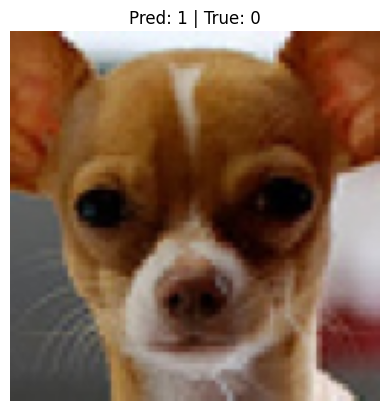

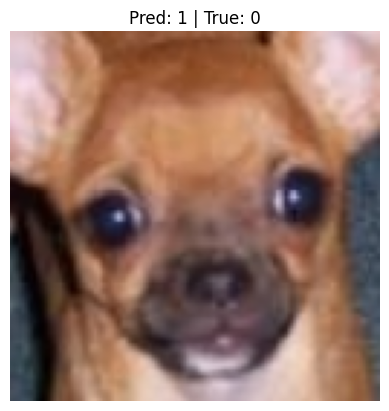

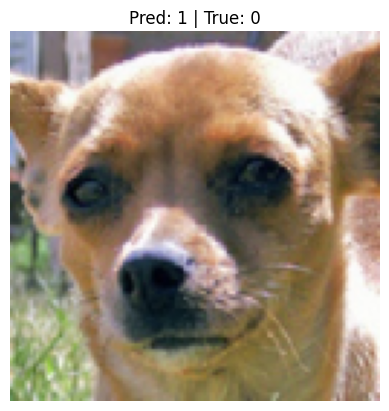

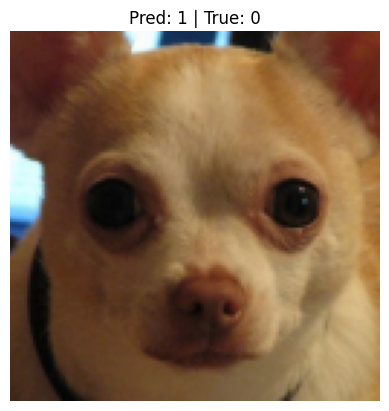

In [50]:
# 4

model.eval()
incorrect_images = []
incorrect_preds = []
incorrect_labels = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(y_test)):
            if predicted[i] != y_test[i]:
                incorrect_images.append(X_test[i])
                incorrect_preds.append(predicted[i])
                incorrect_labels.append(y_test[i])

for i in range(4):
    img = incorrect_images[i].numpy().transpose(1,2,0)

    plt.imshow(img)
    plt.title(f"Pred: {incorrect_preds[i]} | True: {incorrect_labels[i]}")
    plt.axis('off')
    plt.show()